In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
np.random.seed(1)

### Simulation

Here we simulate a single cell dataset for a couple of genes. The gene's expression changes over time according to the function explained bellow. We then assign each cell a (hidden) time and sample their gene expression from this function.


We have two different gene categories:
1. __linear genes__: those are genes that go only up or down over time. This is simulated by a single sigmoid function with varying center and width 
2. __complex genes__: those are genes that go up and down or down and up. This is simulated by two symmetrical sigmoid functions whose start is separated by t_switch time



In [2]:
# meta parameters

k_linear = 10 # number of genes with linear dynamics
k_complex = 10 # number of genes with complex dynamics
n_cells = 1000 
noise = 0.05

In [3]:
def sigmoid(x, a, b): # sigmoid function with parameters a = center; b = width
        return 1/(1+np.exp(-(x-a)/b))
def sigmoid_switch(x, a, b, t_switch):
        return sigmoid(x, a,b) - sigmoid(x-t_switch, a,b)

# sample parameters for simulation of linear genes
neg_linear = np.random.randint(2, size=k_linear) # this parameters determines whether the genes go up or down
a_linear = np.random.uniform(5,15, k_linear)  # offset 
b_linear = np.random.uniform(0,8, k_linear)  # width of the sigmoid function

def simulate_linear_genes(time):
    # this function recovers each gene's values for the provided timepoints
    vals = []
    for i in range(k_linear):
        f = sigmoid(time, a_linear[i], b_linear[i])
        vals.append(1-f if neg_linear[i] else f)
    return np.array(vals).T

# sample parameters for simulation of linear genes
neg = np.random.randint(2, size=k_complex) # this parameters determines whether the genes go up + down or down + up
t_switch = np.random.uniform(5, 15, k_complex)  # switching time point from up to down (or vice-versa)
a = np.random.uniform(0, 5, k_complex)  # offset - determines wether we start with 0 (or max) or in between value
b = np.random.uniform(1,8, k_complex)  # width of the sigmoid function

def simulate_complex_genes(time):
    # this function recovers each gene's values for the provided timepoints
    vals = []
    for i in range(k_complex):
        f = sigmoid_switch(time, a[i], b[i], t_switch[i])
        vals.append(1-f if neg[i] else f)
    return np.array(vals).T

def noise_and_scale(X, noise=0.05): # function to min_max scale and add gaussian noise
    # min_max_scale
    X-=np.min(X, axis=0)
    X/=np.max(X, axis=0)
    # add noise
    X+=np.random.normal(0, noise, X.shape)
    # rescale + get rid of negative values
    X/=np.max(X, axis=0)
    X[X<0]=0
    return X

### Let´s start!

#### (A) Simulation with continuous time

Here each cell has a real continuous time used for fitting

In [4]:
time = np.linspace(0,20,n_cells)

# simulate
linear_X = noise_and_scale(simulate_linear_genes(time), noise)
complex_X = noise_and_scale(simulate_complex_genes(time), noise)

X=np.concatenate((linear_X, complex_X), axis=1)

np.savetxt( "X_continuous_time.csv", X, delimiter=",",fmt='%1.3f')
np.savetxt("t_continuous_time.csv", time, delimiter=",",fmt='%1.1f')

#### (A) Simulation with discrete time

Here we sample cells at a continuous time points $t$. To represent the asynchronous progression of cells through time, the true time of the cell is then assigned to $t+\mathcal{N}(0, 1.5)$

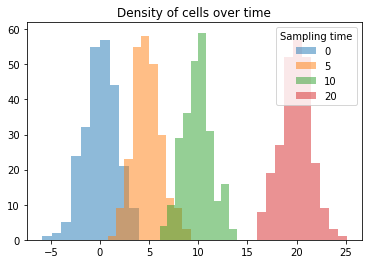

In [5]:
# simulate time 
assigned_time = []
for i in [0, 5, 10, 20]:
    assigned_time.extend(np.repeat(i, int(n_cells/4)))
assigned_time = np.array(assigned_time)    
time = assigned_time + np.random.normal(0, 1.5, n_cells)

for i in np.unique(assigned_time):
    plt.hist(time[assigned_time==i], alpha=0.5, label=i)
plt.title("Density of cells over time")
plt.legend(title="Sampling time", loc='upper right')
plt.show()

In [6]:
# simulate data

linear_X = noise_and_scale(simulate_linear_genes(time), noise)
complex_X = noise_and_scale(simulate_complex_genes(time), noise)

X=np.concatenate((linear_X, complex_X), axis=1)
out_time = np.array([assigned_time, time]).T
np.savetxt( "X_discrete_time.csv", X, delimiter=",",fmt='%1.3f')
np.savetxt("t_discrete_time.csv", out_time, delimiter=",",fmt='%1.1f')

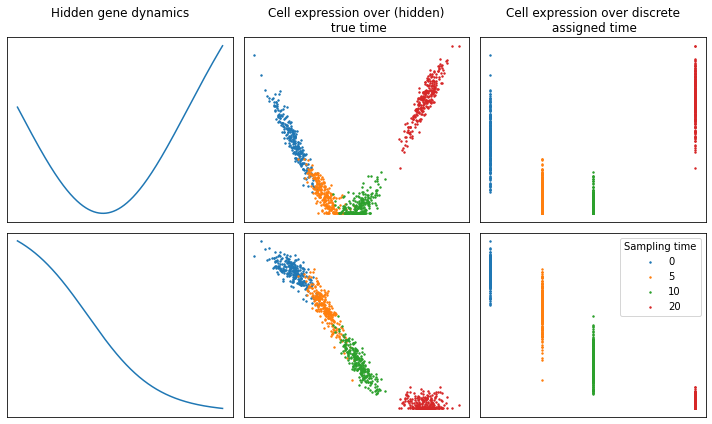

In [16]:
# let's have a look at 2 genes

# hidden dynamics
t = np.linspace(0,20,n_cells)
linear_X = noise_and_scale(simulate_linear_genes(t), 0)
complex_X = noise_and_scale(simulate_complex_genes(t), 0)

f, axs = plt.subplots(2, 3, figsize=(10, 6))

idx = 11 # complex gene idx
axs[0,0].plot(t, complex_X[:,idx-10])
for i in np.unique(assigned_time):
    axs[0,1].scatter(time[assigned_time==i], X[:,idx][assigned_time==i], s=2)
    axs[0,2].scatter(assigned_time[assigned_time==i], X[:,idx][assigned_time==i], s=2)
axs[0,0].set_title("Hidden gene dynamics\n")
axs[0,1].set_title("Cell expression over (hidden)\n true time")
axs[0,2].set_title("Cell expression over discrete\n assigned time")

idx = 1 # simple gene idx
axs[1,0].plot(t, linear_X[:,idx])
for i in np.unique(assigned_time):
    axs[1,1].scatter(time[assigned_time==i], X[:,idx][assigned_time==i], s=2)
    axs[1,2].scatter(assigned_time[assigned_time==i], X[:,idx][assigned_time==i], s=2,
                     label=i)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.legend(title="Sampling time", loc='upper right')
plt.tight_layout()
plt.show()